In [1]:
import numpy as np # linear algebra
import pydicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
import time
import pdb 

### 载入3维图像scan

In [2]:
def load_scan(path):
    # 读入slices存储的是一个序列多个dcm内容的列表
    slices = [pydicom.dcmread(path + '/' + s) for s in os.listdir(path)]
    # 排序
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    # 不懂在检查什么？
    if slices[0].ImagePositionPatient[2] == slices[1].ImagePositionPatient[2]:
        sec_num = 2;
        while slices[0].ImagePositionPatient[2] == slices[sec_num].ImagePositionPatient[2]:
            sec_num = sec_num+1;
        slice_num = int(len(slices) / sec_num)
        slices.sort(key = lambda x:float(x.InstanceNumber))
        slices = slices[0:slice_num]
        slices.sort(key = lambda x:float(x.ImagePositionPatient[2]))
    # 如果z轴的像素间距没有，则通过相邻两幅Dicom切片的Image Position(Patient)相减
    # 得到的结果就是z轴上的像素间距。
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
    # 将像素间距赋值给每一个切片的元数据
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

### 将pixel转为HU

In [3]:
def get_pixels_hu(slices):
    # 2维切片堆叠为3维scan。（矩阵）
    image = np.stack([s.pixel_array for s in slices])

    # 转换为int16类型，有时就是int16类型
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # CT扫描边界之外的灰度值固定为-2000，将这些值设定为0
    image[image==-2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    # 返回image(int16),像素间距（z,x,y)
    return np.array(image, dtype=np.int16), np.array([slices[0].SliceThickness] + list(slices[0].PixelSpacing), dtype=np.float32)

### 单独对每张图二值化

In [4]:
def binarize_per_slice(image, spacing, intensity_th=-600, sigma=1, area_th=30, eccen_th=0.99, bg_patch_size=10):
    # bw存储的就是二值True或False
    bw = np.zeros(image.shape, dtype=bool)
    
    # 准备一个mask.corner的值为nan。也就是正方形中有个内接圆，值为1，其余为nan
    # prepare a mask, with all corner values set to nan
    image_size = image.shape[1]
    grid_axis = np.linspace(-image_size/2+0.5, image_size/2-0.5, image_size)
    x, y = np.meshgrid(grid_axis, grid_axis)
    d = (x**2+y**2)**0.5
    nan_mask = (d<image_size/2).astype(float)
    nan_mask[nan_mask == 0] = np.nan

    # bw开始赋值
    for i in range(image.shape[0]):
        # 检查图像的角像素是否相同，如果相同，则在高斯滤波前与nan_mask相乘
        if len(np.unique(image[i, 0:bg_patch_size, 0:bg_patch_size])) == 1:
            # current_bw为一个二值（与阈值比较后的）
            current_bw = scipy.ndimage.filters.gaussian_filter(np.multiply(image[i].astype('float32'), nan_mask), sigma, truncate=2.0) < intensity_th
        else:
            current_bw = scipy.ndimage.filters.gaussian_filter(image[i].astype('float32'), sigma, truncate=2.0) < intensity_th
        
        # 选择连通区域
        # label函数返回二值图中的连通区的label矩阵，每一个连通区由一个值定义
        label = measure.label(current_bw)
        # regionprops()获取label中每一个连通区的属性。
        properties = measure.regionprops(label)
        # valid_lable是一个有效label值集合
        valid_label = set()
        for prop in properties:
            if prop.area * spacing[1] * spacing[2] > area_th and prop.eccentricity < eccen_th:
                valid_label.add(prop.label)
        # current_bw为符合条件的二值图，利用np.in1d()函数。
        current_bw = np.in1d(label, list(valid_label)).reshape(label.shape)
        bw[i] = current_bw
        
    return bw

### 所有切片一起分析

In [5]:
def all_slice_analysis(bw, spacing, cut_num=0, vol_limit=[0.68, 8.2], area_th=6e3, dist_th=62):
    # 在某些情况下，首先需要删除几个顶层
    # in some cases, several top layers need to be removed first
    if cut_num > 0:
        bw0 = np.copy(bw)
        # bw[-cut_num]后cut_num张
        bw[-cut_num:] = False
    # bw是3维的
    label = measure.label(bw, connectivity=1)
    # remove components access to corners
    mid = int(label.shape[2] / 2)
    # bg_label为以下几个位置的值，set用于去掉重复值
    bg_label = set([label[0, 0, 0], label[0, 0, -1], label[0, -1, 0], label[0, -1, -1], \
                    label[-1-cut_num, 0, 0], label[-1-cut_num, 0, -1], label[-1-cut_num, -1, 0], label[-1-cut_num, -1, -1], \
                    label[0, 0, mid], label[0, -1, mid], label[-1-cut_num, 0, mid], label[-1-cut_num, -1, mid]])
    # label的值已将背景设为0了。
    for l in bg_label:
        label[label == l] = 0
        
    # select components based on volume
    # 通过volume寻找连通区
    properties = measure.regionprops(label)
    for prop in properties:
        if prop.area * spacing.prod() < vol_limit[0] * 1e6 or prop.area * spacing.prod() > vol_limit[1] * 1e6:
            label[label == prop.label] = 0
            
    # prepare a distance map for further analysis
    # 准备一个distance map用作未来的分析
    x_axis = np.linspace(-label.shape[1]/2+0.5, label.shape[1]/2-0.5, label.shape[1]) * spacing[1]
    y_axis = np.linspace(-label.shape[2]/2+0.5, label.shape[2]/2-0.5, label.shape[2]) * spacing[2]
    x, y = np.meshgrid(x_axis, y_axis)
    d = (x**2+y**2)**0.5

    vols = measure.regionprops(label)
    valid_label = set()
    # select components based on their area and distance to center axis on all slices
    for vol in vols:
        single_vol = label == vol.label
        slice_area = np.zeros(label.shape[0])
        min_distance = np.zeros(label.shape[0])
        for i in range(label.shape[0]):
            slice_area[i] = np.sum(single_vol[i]) * np.prod(spacing[1:3])
            min_distance[i] = np.min(single_vol[i] * d + (1 - single_vol[i]) * np.max(d))
        
        if np.average([min_distance[i] for i in range(label.shape[0]) if slice_area[i] > area_th]) < dist_th:
            valid_label.add(vol.label)
    
    # 3维图像中符合条件的二值图。        
    bw = np.in1d(label, list(valid_label)).reshape(label.shape)
    
    # fill back the parts removed earlier
    if cut_num > 0:
        # bw1 is bw with removed slices, bw2 is a dilated version of bw, part of their intersection is returned as final mask
        bw1 = np.copy(bw)
        bw1[-cut_num:] = bw0[-cut_num:]
        bw2 = np.copy(bw)
        bw2 = scipy.ndimage.binary_dilation(bw2, iterations=cut_num)
        bw3 = bw1 & bw2
        label = measure.label(bw, connectivity=1)
        label3 = measure.label(bw3, connectivity=1)
        l_list = list(set(np.unique(label)) - {0})
        valid_l3 = set()
        for l in l_list:
            indices = np.nonzero(label==l)
            l3 = label3[indices[0][0], indices[1][0], indices[2][0]]
            if l3 > 0:
                valid_l3.add(l3)
        bw = np.in1d(label3, list(valid_l3)).reshape(label3.shape)
    
    # 返回bw,以及其中包含的label值的数量。
    return bw, len(valid_label)

### 孔洞填充

In [6]:
def fill_hole(bw):
    # fill 3d holes
    label = measure.label(bw)
    # idendify corner components
    bg_label = set([label[0, 0, 0], label[0, 0, -1], label[0, -1, 0], label[0, -1, -1], \
                    label[-1, 0, 0], label[-1, 0, -1], label[-1, -1, 0], label[-1, -1, -1]])
    bw = ~np.in1d(label, list(bg_label)).reshape(label.shape)
    
    return bw

### 肺部两个肺的掩码

In [7]:
def two_lung_only(bw, spacing, max_iter=22, max_ratio=4.8):    
    def extract_main(bw, cover=0.95):
        for i in range(bw.shape[0]):
            current_slice = bw[i]
            label = measure.label(current_slice)
            properties = measure.regionprops(label)
            properties.sort(key=lambda x: x.area, reverse=True)
            area = [prop.area for prop in properties]
            count = 0
            sum = 0
            while sum < np.sum(area)*cover:
                sum = sum+area[count]
                count = count+1
            filter = np.zeros(current_slice.shape, dtype=bool)
            for j in range(count):
                bb = properties[j].bbox
                filter[bb[0]:bb[2], bb[1]:bb[3]] = filter[bb[0]:bb[2], bb[1]:bb[3]] | properties[j].convex_image
            bw[i] = bw[i] & filter
           
        label = measure.label(bw)
        properties = measure.regionprops(label)
        properties.sort(key=lambda x: x.area, reverse=True)
        bw = label==properties[0].label

        return bw
    
    def fill_2d_hole(bw):
        for i in range(bw.shape[0]):
            current_slice = bw[i]
            label = measure.label(current_slice)
            properties = measure.regionprops(label)
            for prop in properties:
                bb = prop.bbox
                current_slice[bb[0]:bb[2], bb[1]:bb[3]] = current_slice[bb[0]:bb[2], bb[1]:bb[3]] | prop.filled_image
            bw[i] = current_slice

        return bw
    
    # 进行腐蚀
    found_flag = False
    iter_count = 0
    bw0 = np.copy(bw)
    while not found_flag and iter_count < max_iter:
        label = measure.label(bw, connectivity=2)
        properties = measure.regionprops(label)
        properties.sort(key=lambda x: x.area, reverse=True)
        if len(properties) > 1 and properties[0].area/properties[1].area < max_ratio:
            found_flag = True
            bw1 = label == properties[0].label
            bw2 = label == properties[1].label
        else:
            # binary_erosion是腐蚀运算
            bw = scipy.ndimage.binary_erosion(bw)
            iter_count = iter_count + 1
    
    if found_flag:
        # morphology.distance_transform_edt()求距离
        d1 = scipy.ndimage.morphology.distance_transform_edt(bw1 == False, sampling=spacing)
        d2 = scipy.ndimage.morphology.distance_transform_edt(bw2 == False, sampling=spacing)
        bw1 = bw0 & (d1 < d2)
        bw2 = bw0 & (d1 > d2)
                
        bw1 = extract_main(bw1) # 左肺
        bw2 = extract_main(bw2) # 右肺
        
    else:
        bw1 = bw0
        bw2 = np.zeros(bw.shape).astype('bool')
        
    bw1 = fill_2d_hole(bw1) 
    bw2 = fill_2d_hole(bw2)
    bw = bw1 | bw2

    return bw1, bw2, bw

前面都是各种函数定义，下面来实现一个病人3维CT图像肺部mask获取的步骤
### DSB2017stage1中的Example

# CT图像地址
case_path  = "F:/data/DSB2017case/00cba091fa4ad62cc3200a657aeb957e"

# 1、加载scan
case = load_scan(case_path)

# 2、转换为HU，获取spacing
case_pixels, spacing = get_pixels_hu(case)

# 3、对每一张图二值化
bw = binarize_per_slice(case_pixels, spacing)

# 4、除掉一些头部，并进行所有切片分析
flag = 0
cut_num = 0
cut_step = 2
bw0 = np.copy(bw)
while flag == 0 and cut_num < bw.shape[0]:
    bw = np.copy(bw0)

    bw, flag = all_slice_analysis(bw, spacing, cut_num=cut_num, vol_limit=[0.68,7.5])
    cut_num = cut_num + cut_step
    
# 5、 3D孔洞填充
bw = fill_hole(bw)

# 6、分割出肺部
bw1, bw2, bw = two_lung_only(bw, spacing)

In [8]:
case_path = "F:/data/DSB2017case/00cba091fa4ad62cc3200a657aeb957e"

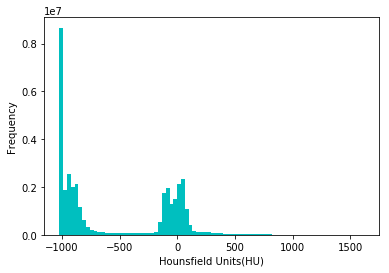

In [9]:
case = load_scan(case_path)
case_pixels, spacing = get_pixels_hu(case)

# 绘制一个直方图看看HU值的分布
plt.hist(case_pixels.flatten(),bins=80,color="c")
plt.xlabel("Hounsfield Units(HU)")
plt.ylabel("Frequency")
plt.show()

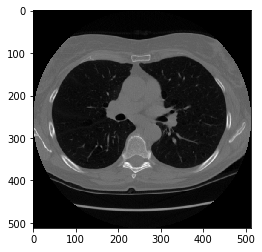

In [10]:
# 显示一个切片
h = 80
plt.imshow(case_pixels[h],cmap=plt.cm.gray)
plt.show()

D:\Soft\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less
D:\Soft\Anaconda3\envs\test\lib\site-packages\skimage\measure\_regionprops.py:250: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_RC_DEPRECATION_MESSAGE)
D:\Soft\Anaconda3\envs\test\lib\site-packages\skimage\measure\_regionprops.py:260: UserWarning: regionprops and image moments (including moments, normalized moments, central moments, and inertia tensor) of 2D images will change from xy coordinates to rc coordinates in version 0.16.
See http://scikit-image.org/docs/0.14.x/release_notes_and_installation.html#deprecations for details on how to avoid this message.
  warn(XY_TO_

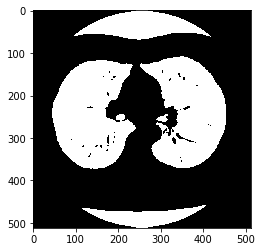

In [11]:
bw = binarize_per_slice(case_pixels, spacing)
plt.imshow(bw[h], cmap=plt.cm.gray)
plt.show()

In [12]:
# time_start=time.time()
pdb.set_trace()
flag = 0
cut_num = 0
while flag == 0:
    bw, flag = all_slice_analysis(bw, spacing, cut_num=cut_num)
    cut_num = cut_num + 1
    print(flag,cut_num)
# time_end=time.time()
# print('totally cost',time_end-time_start)

--Return--
> <ipython-input-12-b53515a17a54>(2)<module>()->None
-> pdb.set_trace()
(Pdb) b 8
Breakpoint 1 at <ipython-input-12-b53515a17a54>:8
(Pdb) b
Num Type         Disp Enb   Where
1   breakpoint   keep yes   at <ipython-input-12-b53515a17a54>:8
(Pdb) c
> <ipython-input-12-b53515a17a54>(8)<module>()->None
-> print(flag,cut_num)
(Pdb) c
1 1


In [ ]:
plt.imshow(bw[h], cmap=plt.cm.gray)
plt.show()

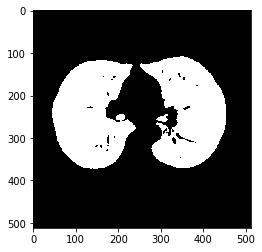

In [14]:
bw = fill_hole(bw)
plt.imshow(bw[h], cmap=plt.cm.gray)
plt.show()

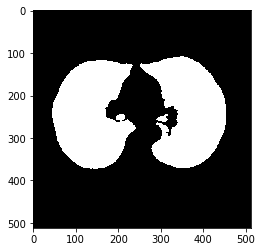

In [15]:
bw1, bw2, bw = two_lung_only(bw, spacing)
plt.imshow(bw[h], cmap=plt.cm.gray)
plt.show()

## 我的原发灶数据的测试

In [13]:
test_data_path = "F:/data/C5YGD35LZ"

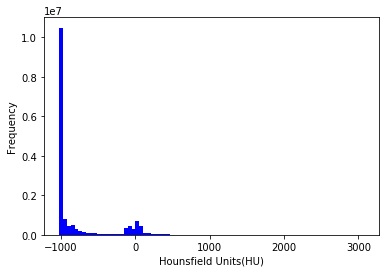

In [14]:
image = load_scan(test_data_path)
image_hu_pixels, spacing = get_pixels_hu(image)

# 绘制一个直方图看看HU值的分布
plt.hist(image_hu_pixels.flatten(),bins=80,color="b")
plt.xlabel("Hounsfield Units(HU)")
plt.ylabel("Frequency")
plt.show()

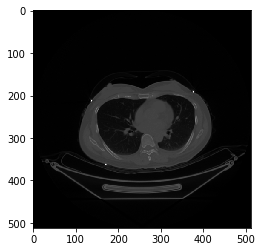

In [10]:
# 显示一个切片
num = 167
plt.imshow(image_hu_pixels[num],cmap=plt.cm.gray)
plt.show()

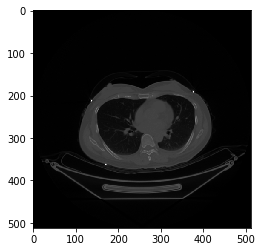

In [17]:
num = 23
plt.imshow(image_hu_pixels[num],cmap=plt.cm.gray)
plt.show()

D:\Soft\Anaconda3\envs\test\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in less


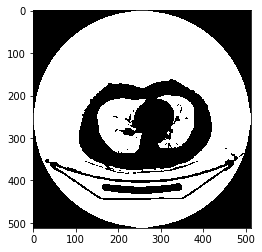

In [18]:
bw = binarize_per_slice(image_hu_pixels, spacing)
plt.imshow(bw[num], cmap=plt.cm.gray)
plt.show()

In [19]:
# time_start=time.time()
pdb.set_trace()
flag = 0
cut_num = 0
while flag == 0:
    bw, flag = all_slice_analysis(bw, spacing, cut_num=cut_num)
    cut_num = cut_num + 1
    print(flag,cut_num)

# time_end=time.time()
# print('totally cost',time_end-time_start)

--Return--
> <ipython-input-19-94e868cf4f92>(2)<module>()->None
-> pdb.set_trace()
(Pdb) b 8
Breakpoint 2 at <ipython-input-19-94e868cf4f92>:8
(Pdb) b
Num Type         Disp Enb   Where
1   breakpoint   keep yes   at <ipython-input-12-b53515a17a54>:8
	breakpoint already hit 1 time
2   breakpoint   keep yes   at <ipython-input-19-94e868cf4f92>:8
(Pdb) cl
Clear all breaks? y
Deleted breakpoint 1 at <ipython-input-12-b53515a17a54>:8
Deleted breakpoint 2 at <ipython-input-19-94e868cf4f92>:8
(Pdb) b 8
Breakpoint 3 at <ipython-input-19-94e868cf4f92>:8
(Pdb) b
Num Type         Disp Enb   Where
3   breakpoint   keep yes   at <ipython-input-19-94e868cf4f92>:8
(Pdb) c
> <ipython-input-19-94e868cf4f92>(8)<module>()->None
-> print(flag,cut_num)
(Pdb) c
1 1


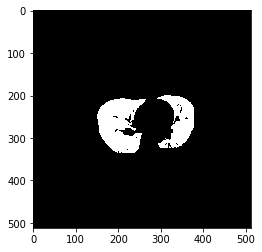

In [20]:
plt.imshow(bw[num], cmap=plt.cm.gray)
plt.show()

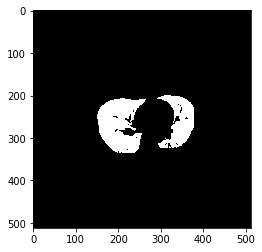

In [21]:
bw = fill_hole(bw)
plt.imshow(bw[num], cmap=plt.cm.gray)
plt.show()

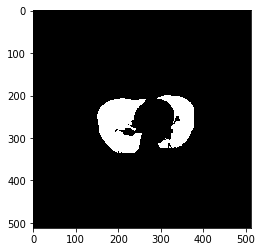

In [22]:
bw1, bw2, bw = two_lung_only(bw, spacing)
plt.imshow(bw[num], cmap=plt.cm.gray)
plt.show()

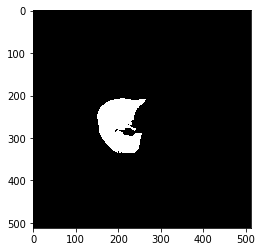

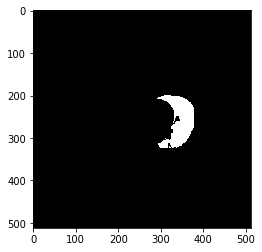

In [23]:
plt.imshow(bw1[num], cmap=plt.cm.gray)
plt.show()
plt.imshow(bw2[num], cmap=plt.cm.gray)
plt.show()